# Warmup Project - Final Iteration

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import thinkstats2

import re

from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

## Data Cleaning

Before a model can be generated from the input data, the dataset first needs to be cleaned. String data have been converted into ints, and missing data have been replaced with default values.

In [2]:
# Importing the dataset...
titanic = pd.read_csv("../../datasets/train.csv")
titanic_test = pd.read_csv("../../datasets/test.csv")
titanic_old = pd.read_csv("../../datasets/train.csv")

# Replaces missing ages w/ the mean
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].mean())

# Replaces sex with integers
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1

# Replaces missing embarked data to "S" and converts to integers
titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 2
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 3

titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")
titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 2
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 3

# Replaces missing fare values in the test data
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic["Fare"].mean())

titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,7.2500,NaN,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,71.2833,C85,2
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,53.1000,C123,1
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,8.0500,NaN,1
5,6,0,3,"Moran, Mr. James",0,29.699118,0,0,330877,8.4583,NaN,3
6,7,0,1,"McCarthy, Mr. Timothy J",0,54.000000,0,0,17463,51.8625,E46,1
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2.000000,3,1,349909,21.0750,NaN,1
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000000,0,2,347742,11.1333,NaN,1
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.000000,1,0,237736,30.0708,NaN,2


## New Features

Additional features can be constructed from pre-existing data, such as the size of each person's family and the name length. People with large families probably would have had more people to help them escape, and long names could correlate with passenger class.

In [3]:
# Synthesizes new features
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

Another feature I investigated was the title of each person - people who had higher social statuses probably would have been the first to board the lifeboats.

In [4]:
# Extracts the title from each person's name
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

titles = titanic["Name"].apply(get_title)
titles_test = titanic_test["Name"].apply(get_title)

title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5,
                 "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8,
                 "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10,
                 "Sir": 9, "Capt": 7, "Ms": 2, "Dona": 10}
for k,v in title_mapping.items():
    titles[titles == k] = v
    titles_test[titles_test == k] = v
    
titanic["Title"] = titles
titanic_test["Title"] = titles_test

In a similar vein, I extracted numerical values from the "Ticket" column and saved it into a new feature called "TicketNo."

In [5]:
def get_ticket_no(ticket):
    ticket_no_search = re.findall(r'\d+', ticket)
    if ticket_no_search:
        return int(ticket_no_search[0])
    return 0

titanic["TicketNo"] = titanic["Ticket"].apply(get_ticket_no)
titanic_test["TicketNo"] = titanic_test["Ticket"].apply(get_ticket_no)

## Key Trends

In order to detect important trends in the data, I plotted various variables against each other.

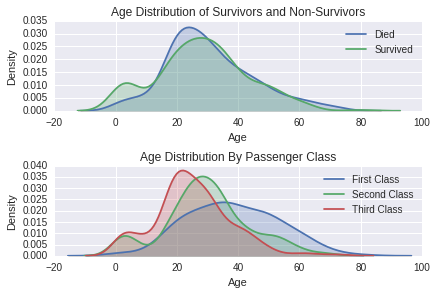

In [6]:
# Plots age distribution of people who died / survived
died = titanic_old[titanic_old.Survived == 0]
survived = titanic_old[titanic_old.Survived == 1]

plt.subplot(2,1,1)
sns.kdeplot(died.Age, shade=True)
sns.kdeplot(survived.Age, shade=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution of Survivors and Non-Survivors')
plt.legend(('Died', 'Survived'),loc='best') 


# Plots age distribution based on class
class1 = titanic_old[titanic_old.Pclass == 1]
class2 = titanic_old[titanic_old.Pclass == 2]
class3 = titanic_old[titanic_old.Pclass == 3]

plt.subplot(2,1,2)
sns.kdeplot(class1.Age, shade=True)
sns.kdeplot(class2.Age, shade=True)
sns.kdeplot(class3.Age, shade=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Age Distribution By Passenger Class')
plt.legend(('First Class', 'Second Class', 'Third Class'),loc='best')


plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

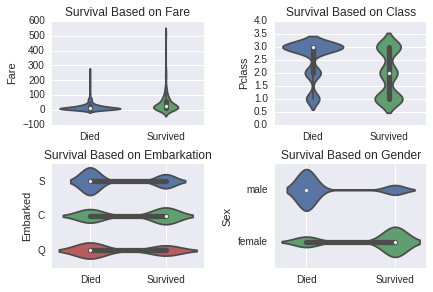

In [7]:
# Distribution based on fare
plt.subplot(2,2,1)
plt.title('Survival Based on Fare')
sns.violinplot(x=titanic.Survived, y=titanic.Fare)
plt.xticks(titanic.Survived, ["Died", "Survived"])
plt.xlabel('')

# Distribution based on passenger class
plt.subplot(2,2,2)
plt.title('Survival Based on Class')
sns.violinplot(x=titanic.Survived, y=titanic.Pclass)
plt.xticks(titanic.Survived, ["Died", "Survived"])
plt.xlabel('')

# Distribution based on port of embarkation
plt.subplot(2,2,3)
plt.title('Survival Based on Embarkation')
plt.xticks(titanic_old.Survived, ["Died", "Survived"])
sns.violinplot(x=titanic_old.Survived, y=titanic_old.Embarked)
plt.xlabel('')

# Distribution based on gender
plt.subplot(2,2,4)
plt.title('Survival Based on Gender')
plt.xticks(titanic_old.Survived, ["Died", "Survived"])
sns.violinplot(x=titanic_old.Survived, y=titanic_old.Sex)
plt.xlabel('')

plt.tight_layout(pad=0.6, w_pad=1, h_pad=1.0)

## Model Design and Validation

According to the above plots, people who paid more for their fare or were in a higher passenger class tended to have higher chances of survival. Additionally, children and women seemed to have high survival rates, as well. The random forests algorithm can take advantage of these categorical trends in the data distribution, since it is clear that people in certain categories have a higher chance of survival than others (1st class, female, young).

I also used a logistic regression algorithm and ensembled the two algorithms together to mitigate overfitting. I weighted the random forest classifier more because it seemed to provivde more accurate results.

In [8]:
# Parameters to consider
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "NameLength", "Title", "TicketNo"]

# Generates random forests to fit the data and cross-validates the model
algorithms = [RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=8, min_samples_leaf=4),
              LogisticRegression(random_state=1)]

# Cross validates the model using KFold
kf = KFold(titanic.shape[0], n_folds=3, random_state=1)

predictions = []
for train, test in kf:
    train_target = titanic["Survived"].iloc[train]
    full_test_predictions = []

    for alg in algorithms:
        alg.fit(titanic[predictors].iloc[train,:], train_target)
        test_predictions = alg.predict_proba(titanic[predictors].iloc[test,:].astype(float))[:,1]
        full_test_predictions.append(test_predictions)

    # Ensembles the algorithms by weighting the random forest classifier more
    test_predictions = full_test_predictions[0]*.8 + full_test_predictions[1]*.2
    test_predictions[test_predictions <= .5] = 0
    test_predictions[test_predictions > .5] = 1
    predictions.append(test_predictions)

# Put all the predictions together into one array.
predictions = np.concatenate(predictions, axis=0)
print "Accuracy: "
print len(titanic[titanic.Survived == predictions]) / float(len(titanic))

Accuracy: 
0.83164983165


In [9]:
# Makes predictions based on this model
predictions = []
for alg in algorithms:
    predictions.append(alg.predict(titanic_test[predictors]))
predictions = predictions[0] * 0.8 + predictions[1] * 0.2
predictions[predictions <= .5] = 0
predictions[predictions > .5] = 1
predictions = predictions.astype(int)

# Generates a new submission
submission = pd.DataFrame({
        "PassengerId": titanic_test["PassengerId"],
        "Survived": predictions
    })

submission.to_csv("submission_iteration2.csv", index=False)

According to Kaggle, this model's accuracy is 78.95%, which is fairly higher than the previous score that I received (~76%). After adding more features and using a combination of two complementary algorithms, I increased the cross-validation accuracy by a few percentage points. Thus, the higher score I received on Kaggle seemed to make sense.

One way to discover flaws in the model is to observe the distribution of people that the model failed to predict correctly. As the following plots show, there are several clear weaknesses to the model, but it is difficult to determine if there is a clear trend pointing to a specific cause.

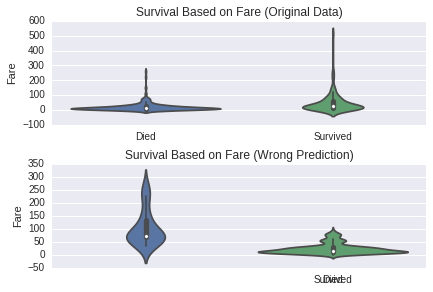

In [10]:
predictions = alg.predict(titanic[predictors])
wrong = titanic_old[titanic.Survived != predictions]

# Distribution based on fare
plt.subplot(2,1,1)
plt.title('Survival Based on Fare (Original Data)')
sns.violinplot(x=titanic.Survived, y=titanic.Fare)
plt.xticks(titanic.Survived, ["Died", "Survived"])
plt.xlabel('')

plt.subplot(2,1,2)
plt.title('Survival Based on Fare (Wrong Prediction)')
sns.violinplot(x=wrong.Survived, y=wrong.Fare)
plt.xticks(wrong.Survived, ["Died", "Survived"])
plt.xlabel('')

plt.tight_layout(pad=0.6, w_pad=1, h_pad=1.0)

The model seemed to incorrectly guess that many passengers who paid very little for their fare ended up dying. However, many of these passengers actually survived.

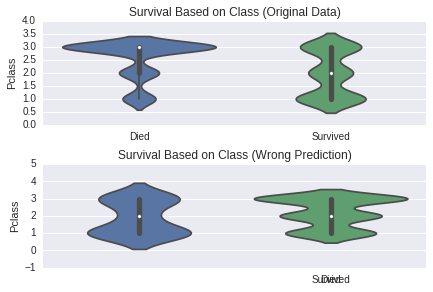

In [11]:
# Distribution based on passenger class
plt.subplot(2,1,1)
plt.title('Survival Based on Class (Original Data)')
sns.violinplot(x=titanic.Survived, y=titanic.Pclass)
plt.xticks(titanic.Survived, ["Died", "Survived"])
plt.xlabel('')

plt.subplot(2,1,2)
plt.title('Survival Based on Class (Wrong Prediction)')
sns.violinplot(x=wrong.Survived, y=wrong.Pclass)
plt.xticks(wrong.Survived, ["Died", "Survived"])
plt.xlabel('')

plt.tight_layout(pad=0.6, w_pad=1, h_pad=1.0)

Here, the model seemed to do a good job predicting death for 2nd class passengers, but it seemed to do worse for making other predictions.

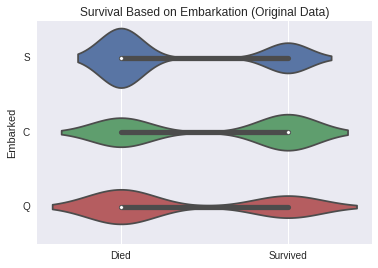

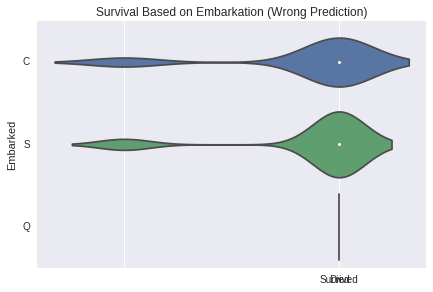

In [12]:
# Distribution based on port of embarkation
plt.title('Survival Based on Embarkation (Original Data)')
plt.xticks(titanic_old.Survived, ["Died", "Survived"])
sns.violinplot(x=titanic_old.Survived, y=titanic_old.Embarked)
plt.xlabel('')
plt.show()

# Distribution based on port of embarkation
plt.title('Survival Based on Embarkation (Wrong Prediction)')
plt.xticks(wrong.Survived, ["Died", "Survived"])
sns.violinplot(x=wrong.Survived, y=wrong.Embarked)
plt.xlabel('')

plt.tight_layout(pad=0.6, w_pad=1, h_pad=1.0)

Here, the model correctly guessed the fates for most of the people who embarked at Queenstown, but did not do so well for the other ports.

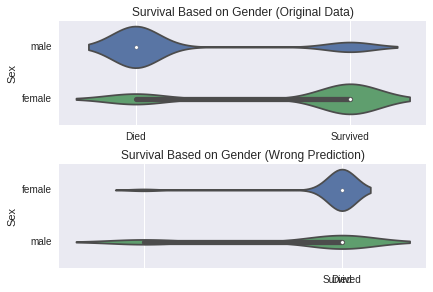

In [13]:
# Distribution based on gender
plt.subplot(2,1,1)
plt.title('Survival Based on Gender (Original Data)')
plt.xticks(titanic_old.Survived, ["Died", "Survived"])
sns.violinplot(x=titanic_old.Survived, y=titanic_old.Sex)
plt.xlabel('')

plt.subplot(2,1,2)
plt.title('Survival Based on Gender (Wrong Prediction)')
plt.xticks(wrong.Survived, ["Died", "Survived"])
sns.violinplot(x=wrong.Survived[1:], y=wrong.Sex[1:]) # Removing the first element makes the graphs match better
plt.xlabel('')

plt.tight_layout(pad=0.6, w_pad=1, h_pad=1.0)

The model seemed to guess that more men died, when in actuality, there were quite a few men who survived that the model did not account for.

## Future Work

As mentioned, the model can clearly be improved in several ways, and it would be interesting to observe the trends in the dataset more closely, particularly where the model guessed incorrectly. It may also be worth investigating other supervised learning algorithms, such as neural networks or support vector machines. Perhaps a different combination of these algorithms could provide better results.

Additionally, it would be interesting to look more into the actual layout of the rooms in the Titanic. It is likely that people who were in the lower regions of the ship had significantly lower chances of survival, and from the cabin and ticket data, it may be possible to extrapolate each passenger's locations in the ship. 

## Sources

https://www.dataquest.io/mission/75/improving-your-submission

http://nbviewer.jupyter.org/github/agconti/kaggle-titanic/blob/master/Titanic.ipynb